# Praca domowa nr 2 - Sebastian Deręgowski

Na początek zaimportujmy wszystkie potrzebne biblioteki:

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from category_encoders import TargetEncoder, OneHotEncoder, PolynomialEncoder, CountEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error as rmse

Wczytajmy nasz zbiór danych i przyjrzyjmy mu się:

In [18]:
allegro = pd.read_csv("allegro-api-transactions.csv")
allegro.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


Wszystkie rodzaje encodingu będziemy wykonywać na kopiach, aby nie modyfikować wyjściowej ramki danych.

## 1. Kodowanie zmiennych kategorycznych

Jak widzimy, zmienna *it_location*, na której będziemy zaraz wykonywać target encoding, zawiera różne formaty tekstowe. Przed przystąpieniem do target encoddingu ujednolićmy je w celu lepszego pogrupowania.

In [19]:
target_encoder = TargetEncoder()
allegro_target = allegro.copy()
allegro_target[["it_location"]] = allegro_target[["it_location"]].apply(lambda x: x.str.lower())
savings = allegro_target["it_location"].unique().size
allegro_target["it_location"] = target_encoder.fit_transform(allegro_target["it_location"],allegro_target["price"])
allegro_target.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,84.132898,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,84.132898,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,64.883187,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,35.433365,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,73.772916,"Odzież, Obuwie, Dodatki"


Podstawową zaletą target encodingu nad one hot encodingiem jest to, że nie zmieniamy liczby kolumn w naszej ramce danych. W przypadku zbioru allegro oszczędziliśmy w ten sposób dodanie dokładnie tylu nowych kolumn:

In [20]:
savings

7903

Z drugiej strony wprowadziliśmy teraz sztuczną relację porządku na zmiennych, która nie jest dla nich naturalna. Dodatkowo, ponieważ target encoding przypisuje jako wartość średnią wartość zmiennej celu, to jest ona narażona na zaburzenia, jako że średnia jest bardzo wrażliwa na outliery.

Teraz wykonamy one hot encoding dla kolumny *main_category*. W tym celu tak jak poprzednio stworzymy kopię wyjściowej ramki, sprawdźmy też wcześniej, ile nowych kolumn w ten sposób powstanie:

In [21]:
allegro_onehot = allegro.copy()
allegro["main_category"].unique().size

27

In [22]:
onehot_encoder = OneHotEncoder(use_cat_names=True)
allegro_onehot = allegro_onehot.join(onehot_encoder.fit_transform(allegro_onehot["main_category"])).drop("main_category",axis=1)
allegro_onehot.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,...,main_category_Filmy,main_category_Fotografia,main_category_Biuro i Reklama,main_category_Instrumenty,main_category_Muzyka,main_category_Konsole i automaty,"main_category_Sprzęt estradowy, studyjny i DJ-ski",main_category_Antyki i Sztuka,main_category_Bilety,main_category_Nieruchomości
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,...,0,0,0,0,0,0,0,0,0,0
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,...,0,0,0,0,0,0,0,0,0,0
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,...,0,0,0,0,0,0,0,0,0,0
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,...,0,0,0,0,0,0,0,0,0,0
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,...,0,0,0,0,0,0,0,0,0,0


Teraz przyjrzymy się jak działa polynomial encoding:

In [23]:
polynomial_encoder = PolynomialEncoder()
allegro_polynomial = allegro.copy()
allegro_polynomial = allegro_polynomial.join(polynomial_encoder.fit_transform(allegro_polynomial["main_category"])).drop("main_category",axis=1)
allegro_polynomial.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,...,main_category_16,main_category_17,main_category_18,main_category_19,main_category_20,main_category_21,main_category_22,main_category_23,main_category_24,main_category_25
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,...,-0.002429,0.001117,-0.000478,0.000189,-0.000069,0.000022,-0.000006,0.000002,-3.206860e-07,4.490498e-08
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,...,0.026161,-0.013576,0.006512,-0.002868,0.001149,-0.000413,0.000131,-0.000035,7.696464e-06,-1.167529e-06
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,...,-0.119078,0.071643,-0.039341,0.019631,-0.008835,0.003543,-0.001243,0.000370,-8.818865e-05,1.459412e-05
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,...,0.286143,-0.209481,0.136451,-0.079261,0.040921,-0.018611,0.007334,-0.002432,6.413720e-04,-1.167530e-04
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,...,0.026161,-0.013576,0.006512,-0.002868,0.001149,-0.000413,0.000131,-0.000035,7.696464e-06,-1.167529e-06


Jak widzimy, encoding stworzył nam 25 kolumn odpowiadających kolejnym współczynnikom w wielomianie kodującym naszą zmienną. Na koniec przyjrzyjmy się jak działa CountEncoder():

In [24]:
allegro["main_category"].value_counts()

Dom i Ogród                            91042
Odzież, Obuwie, Dodatki                54257
Motoryzacja                            45941
Dla Dzieci                             42107
Uroda                                  28096
Sport i Turystyka                      27532
RTV i AGD                              20341
Telefony i Akcesoria                   19805
Komputery                              14491
Zdrowie                                13166
Książki i Komiksy                      11572
Delikatesy                              8074
Gry                                     7150
Rękodzieło                              6574
Kolekcje                                6146
Przemysł                                5959
Biżuteria i Zegarki                     5808
Biuro i Reklama                         3194
Fotografia                              2381
Muzyka                                  1961
Antyki i Sztuka                         1214
Konsole i automaty                      1053
Filmy     

In [25]:
count_encoder = CountEncoder()
allegro_count = allegro.copy()
allegro_count["main_category"] = count_encoder.fit_transform(allegro_count["main_category"])
allegro_count.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,14491
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,54257
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,91042
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,11572
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,54257


Jak widzimy, teraz zamiast nazwy kategorii mamy liczbę wszystkich rekordów w tej kategorii. Jest to rozwiązanie dość niebezpieczne, bo w przypadku gdy dwie lub więcej danych kategorii mają tyle samo rekordów, przestaną one być rozróżnialne. Dodatkowo ponownie tworzymy sztuczną relację porządku, która może mieć wpływ na interpretację danych przez model.

## 2. Uzupełnianie braków

In [26]:
allegro_numeric = allegro[["price","it_seller_rating","it_quantity"]]
allegro_numeric.head()

,price,it_seller_rating,it_quantity
0,59.99,50177,997
1,4.90,12428,9288
2,109.90,7389,895
3,18.50,15006,971
4,19.90,32975,950


Z racji na duży rozmiar danych i długi czas wykonywania (szczególnie pętli) nasze operacje będziemy wykonywać na próbce 10%. Utworzymy również kopię, aby móc potem obliczyć RMSE.

In [27]:
allegro_numeric = allegro_numeric.sample(n=int(allegro_numeric.shape[0]/10)).reset_index(drop=True)
deleted_rows = np.random.randint(len(allegro_numeric),size=int(len(allegro_numeric)/10))
allegro_numeric_copy = allegro_numeric.copy()
allegro_numeric_copy.loc[deleted_rows,'it_seller_rating'] = np.nan
allegro_numeric_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42002 entries, 0 to 42001
Data columns (total 3 columns):
price               42002 non-null float64
it_seller_rating    38020 non-null float64
it_quantity         42002 non-null int64
dtypes: float64(2), int64(1)
memory usage: 984.5 KB


Widzimy, że kategoria *it_seller_rating* ma 10% nullowych wartości. Teraz uzupełnimy te braki przy pomocy imputacji nearest neighbors.

In [28]:
knn_imputer = KNNImputer(weights="uniform",n_neighbors=5)
allegro_numeric_copy = knn_imputer.fit_transform(allegro_numeric_copy)
allegro_numeric_copy = pd.DataFrame(allegro_numeric_copy, columns = ["price", "it_seller_rating", "it_quantity"])
rmse(allegro_numeric.it_seller_rating, allegro_numeric_copy.it_seller_rating)

142831407.1507538

Jak widzimy, RMSE wyszło gigantyczne. Teraz wykonamy eksperyment powtarzając powyższe czynności jeszcze 9 razy i obliczmy odchylenie standardowe wyników.

In [29]:
rmse_knn = [rmse(allegro_numeric.it_seller_rating, allegro_numeric_copy.it_seller_rating)]
for i in range(9):
    deleted_rows = np.random.randint(len(allegro_numeric),size=int(len(allegro_numeric)/10))
    allegro_numeric_copy = allegro_numeric.copy()
    allegro_numeric_copy.loc[deleted_rows,'it_seller_rating'] = np.nan
    allegro_numeric_copy = knn_imputer.fit_transform(allegro_numeric_copy)
    allegro_numeric_copy = pd.DataFrame(allegro_numeric_copy, columns = ["price", "it_seller_rating", "it_quantity"])
    rmse_knn.append(rmse(allegro_numeric.it_seller_rating, allegro_numeric_copy.it_seller_rating))
print("Średnia: " + str(np.mean(rmse_knn)))
print("Odchylenie standardowe: " + str(np.std(rmse_knn)))

Średnia: 140604470.48285833
Odchylenie standardowe: 4052918.2790168514


Teraz powtórzymy eksperyment, tym razem usuwając wartości z dwóch kolumn.

In [30]:
rmse_knn_seller = []
rmse_knn_quantity = []
for i in range(10):
    deleted_rows = np.random.randint(len(allegro_numeric),size=int(len(allegro_numeric)/10))
    deleted_rows2 = np.random.randint(len(allegro_numeric),size=int(len(allegro_numeric)/10))
    allegro_numeric_copy = allegro_numeric.copy()
    allegro_numeric_copy.loc[deleted_rows,'it_seller_rating'] = np.nan
    allegro_numeric_copy.loc[deleted_rows,'it_quantity'] = np.nan
    allegro_numeric_copy = knn_imputer.fit_transform(allegro_numeric_copy)
    allegro_numeric_copy = pd.DataFrame(allegro_numeric_copy, columns = ["price", "it_seller_rating", "it_quantity"])
    rmse_knn_seller.append(rmse(allegro_numeric.it_seller_rating, allegro_numeric_copy.it_seller_rating))
    rmse_knn_quantity.append(rmse(allegro_numeric.it_quantity, allegro_numeric_copy.it_quantity))
print("Średnia wartość RMSE dla kolumny it_seller_rating: " + str(np.mean(rmse_knn_seller)))
print("Średnia wartość RMSE dla kolumny it_quantity: " + str(np.mean(rmse_knn_quantity)))
print("Odchylenie standardowe RMSE dla kolumny it_seller_rating: " + str(np.std(rmse_knn_seller)))
print("Odchylenie standardowe RMSE dla kolumny it_quantity: " + str(np.std(rmse_knn_quantity)))

Średnia wartość RMSE dla kolumny it_seller_rating: 147815141.5588871
Średnia wartość RMSE dla kolumny it_quantity: 61055584.81564412
Odchylenie standardowe RMSE dla kolumny it_seller_rating: 5943737.843101496
Odchylenie standardowe RMSE dla kolumny it_quantity: 1142020.891233039


Na sam koniec zwizualizujemy wyniki przy pomocy wykresów skrzynkowych:

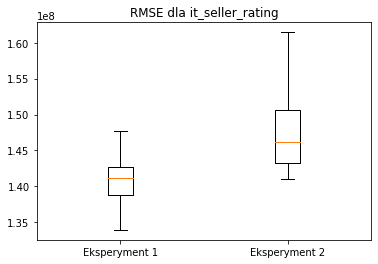

In [31]:
fig, ax = plt.subplots()
plt.title("RMSE dla it_seller_rating")
ax.set_xticklabels(["Eksperyment 1", "Eksperyment 2"])
ax.boxplot([rmse_knn, rmse_knn_seller])
plt.show()

Jak widzimy, w drugim eksperymencie błąd jeszcze bardziej wzrósł. Jak się jednak okazuje, dla kolumny *it_quantity* był znacząco mniejszy (choć wciąż ogromny).

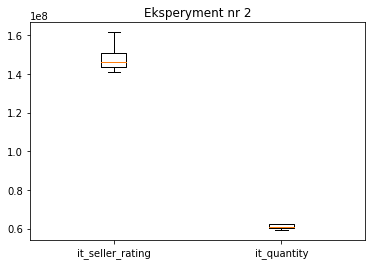

In [32]:
fig, ax = plt.subplots()
plt.title("Eksperyment nr 2")
ax.set_xticklabels(["it_seller_rating", "it_quantity"])
ax.boxplot([rmse_knn_seller, rmse_knn_quantity])
plt.show()